# Create final plots for Prelim-Proposal

This script creates plots which combine at least two different methods. The plots were used in the Prelim-Proposal.

In [37]:
# import useful packages
import obspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from obspy import UTCDateTime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm
import sys

## Plot Spectrogram & covariance eiganvalues

In [181]:
#=========================================== define parameters =============================================================
year = 2004
jdays = range(275,275+1)
jday = jdays[0]
hour = 18
signal_duration_sec = 4 * 3600 # hour * sec

window_duration_sec = 30
average = 10

In [185]:
# read stacked stream for stream plot and specktrogram
st_stack = obspy.read("/home/koepflma/project1/Mt-St-Helens/noise_analysis/stack_expl{}_EDM_SHW_SOS_JUN_ELK_TDL_YEL_FL2_CDF_SEP.mseed".format(jday))
tr = st_stack[0]
tr_copy = tr.copy()

In [186]:
#========================================= calculate spectrogram ==============================================
def calc_spec(tr, 
              NFFT,
              noverlap=0,         # overlap in samples
              detrend='linear',   # detrending before taking fourier transform
              mode='psd',         # 'psd', 'magnitude', 'angle', 'phase'
              scale_by_freq=True, # unit/Hz
              scale='dB',         # 'linear', 'dB'
              **kwargs):
    '''calculates a spectrogram from an obspy trace'''
    
    data = tr.data
    fs = tr.stats.sampling_rate #sampling rate
    Pxx, freqs, bins, _ = plt.specgram(data, 
                                    NFFT=NFFT, 
                                    Fs=fs, 
                                    noverlap=noverlap,
                                    detrend=detrend, 
                                    mode=mode,
                                    scale_by_freq=scale_by_freq,
                                    scale=scale,
                                    **kwargs)
    plt.close() # for execution in Jupyter Notebook/Lab
    return Pxx, freqs, bins, tr.stats

# Pxx, freqs, bins, stats = calc_spec(tr, NFFT=int(tr.stats.sampling_rate*180))#, NFFT=int(tr.stats.sampling_rate*600))
Pxx, freqs, bins, stats = calc_spec(tr, NFFT=int(tr.stats.sampling_rate*30))

In [187]:
#========================================= load spectral width ===============================================
def load_files(year,jdays,window_duration_sec,average,preprocessing_type):

#     file_path = '/data/whd02/MtStHelens_manuela/covariance/{}/'.format(year)
    file_path = '/data/wsd03/data_manuela/MtStHelens/covariance/tremor/{}/'.format(year)
#     file_path = '/data/wsd03/data_manuela/MtStHelens/covariance/{}/'.format(year)


    for i, jday in enumerate(jdays):
        file_name = '{:03d}/{}_{}_{:03d}_wd{}_av{}'.format(jday,preprocessing_type,year,jday,int(window_duration_sec), average)

        ar = np.load(file_path+file_name+'.npz', allow_pickle=True)

        if i == 0:
            UTC_times = ar['UTC_times']
            frequencies = ar['frequencies']
            spectral_width = ar['spectral_width']/ar['n_sta']
            n_sta = np.full(len(ar['UTC_times']),ar['n_sta'])
        else:       
            spectral_width = np.concatenate((spectral_width, ar['spectral_width']/ar['n_sta']))
            UTC_times = np.concatenate((UTC_times, ar['UTC_times']))
            n_sta = np.concatenate((n_sta, np.full(len(ar['UTC_times'])-1,ar['n_sta'])))

#         sys.stdout.write('\r{} of {}'.format(i+1, len(jdays)))
#         sys.stdout.flush()

    # to remove the last time per day 23:59:59 and only keep the first one of the new day 00:00
    UTC_times = np.array([t.datetime for i,t in enumerate(UTC_times,1) if t.second != 59]) 
    # add midnight of next day as datetime.datetime
#     UTC_times = np.append(UTC_times,datetime.datetime.combine(UTC_times[-1].date()+
#                                                          datetime.timedelta(days=1), 
#                                                          datetime.datetime.min.time()))
    print('\n', UTC_times.shape, frequencies.shape, spectral_width.shape)
    
    return UTC_times, frequencies, n_sta, spectral_width

In [174]:
# check the shape of the spectral width
UTC_times, frequencies, n_sta, spectral_width1 = load_files(year,jdays,window_duration_sec,average,'NoPreP')
UTC_times, frequencies, n_sta, spectral_width2 = load_files(year,jdays,window_duration_sec,average,'OBT')
UTC_times, frequencies, n_sta, spectral_width3 = load_files(year,jdays,window_duration_sec,average,'OBS')
UTC_times, frequencies, n_sta, spectral_width4 = load_files(year,jdays,window_duration_sec,average,'ST')


 (190,) (6000,) (190, 5999)

 (190,) (6000,) (190, 5999)

 (190,) (6000,) (190, 5999)

 (190,) (6000,) (190, 5999)


In [175]:
n_sta[0]

10

In [70]:
!ls /data/whd02/MtStHelens_manuela/covariance/2005/004

NoPreP_2005_004_wd30_av60.npz  OBT_2005_004_wd30_av60.npz
NoPreP_2005_004_wd60_av60.npz  OBT_2005_004_wd60_av60.npz
OBS_2005_004_wd30_av60.npz     ST_2005_004_wd30_av60.npz
OBS_2005_004_wd60_av60.npz     ST_2005_004_wd60_av60.npz


/tmp/ipykernel_3358519/859421284.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(


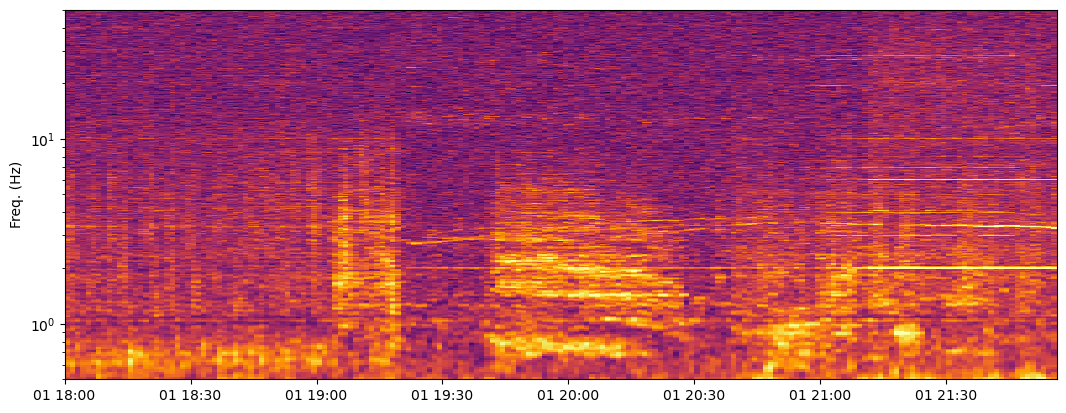

In [177]:
fig, ax = plt.subplots(1,1, sharex=True,figsize=(6.4*2, 4.8))
img = ax.pcolormesh(
    UTC_times, frequencies, spectral_width3.T, rasterized=True, cmap="inferno_r",
    vmin=0.05, vmax=0.25)
ax.set_ylim([5e-1, st_stack[0].stats.sampling_rate / 2])
ax.set_ylabel("Freq. (Hz)")
ax.set_yscale('log')

In [158]:
# resample trace for seismogram
import numpy.ma as ma
tr_copy.data = ma.masked_array(data=tr_copy.data,
             mask=np.isnan(tr_copy.data))

st_res = tr_copy.split()
st_res.resample(50)
st_res.merge(fill_value=np.nan)
stream_plot = st_res[0]

/tmp/ipykernel_3358519/2301890085.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax1.pcolormesh(
/tmp/ipykernel_3358519/2301890085.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax2.pcolormesh(
/tmp/ipykernel_3358519/2301890085.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'n

Text(0.5, 0, 'Time (UTC)')

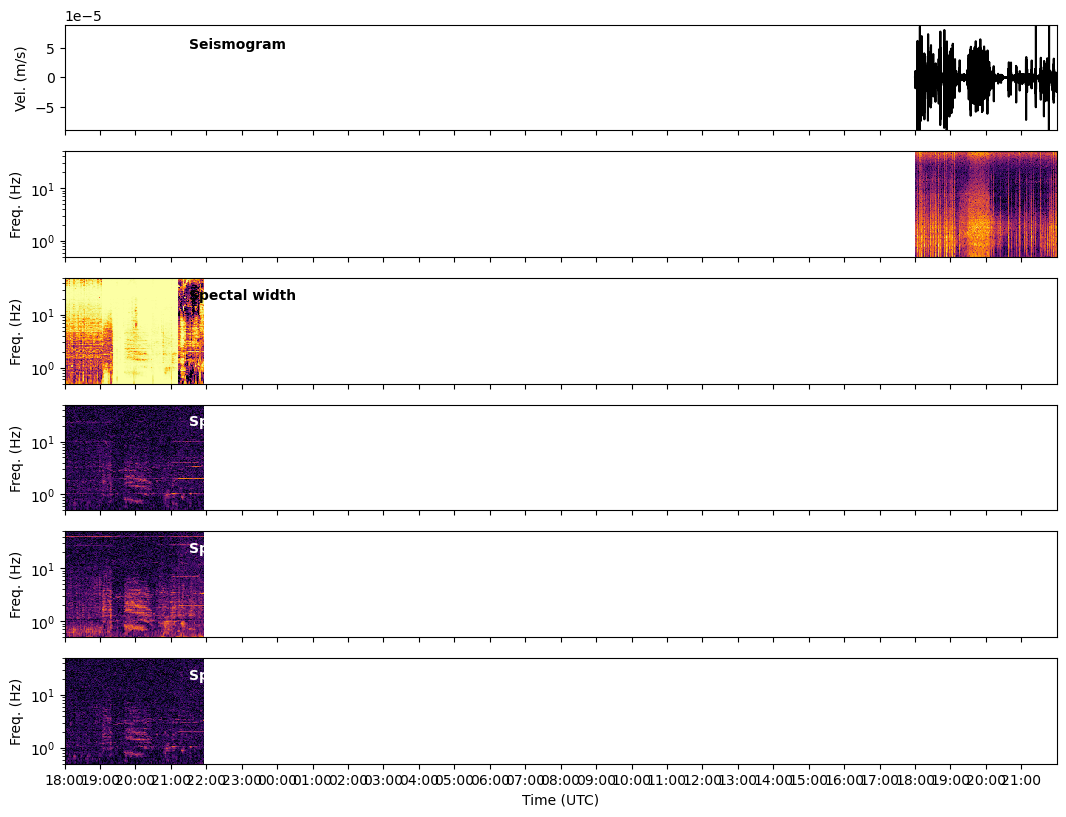

In [180]:
#=============================================== plotting======================================================
# create plot #1 - no preprocessin------------------------------------------------------------------
fig, (ax0,ax,ax1,ax2,ax3,ax4) = plt.subplots(6,1, sharex=True,figsize=(6.4*2, 4.8*2))
ax0.plot(np.arange(stream_plot.stats.starttime.datetime, stream_plot.stats.endtime.datetime, datetime.timedelta(seconds=stream_plot.stats.delta)).astype(datetime.datetime),stream_plot.data[:-1], 'k')
ax0.set_ylabel("Vel. (m/s)")
ax0 .set_ylim(-9e-5, 9e-5)
ax0.text(UTCDateTime(year=year,julday=jday,hour=hour+3,minute=30), 5e-5, 'Seismogram', color='black', weight='bold')

img = ax.pcolormesh(np.arange(stats.starttime.datetime, stats.endtime.datetime, datetime.timedelta(seconds=bins[0]*2)).astype(datetime.datetime),
                    freqs,10*np.log10(Pxx), cmap='inferno',vmin=-180, vmax=-100, shading='auto')
ax.set_ylabel("Freq. (Hz)")
ax.text(UTCDateTime(year=year,julday=jday,hour=hour+3,minute=30), 20, 'Spectrogram', color='white', weight='bold')

# show network covariance matrix spectral width
#fig, ax = plt.subplots(1, constrained_layout=True)
img = ax1.pcolormesh(
    UTC_times, frequencies, spectral_width1.T, rasterized=True, cmap="inferno_r",
    vmin=0, vmax=0.1)

ax1.set_ylabel("Freq. (Hz)")
ax1.text(UTCDateTime(year=year,julday=jday,hour=hour+3,minute=30), 20, 'Spectal width', color='black', weight='bold')
# ax1.set_title("No preprocessing")
# plt.colorbar(img, ax=ax1).set_label("Covariance matrix spectral width")

# create plot #2 - preprocess data with one-bit spectral whitening----------------------------------
# show network covariance matrix spectral width
#fig, ax = plt.subplots(1, constrained_layout=True)
img = ax2.pcolormesh(
    UTC_times, frequencies, spectral_width2.T, rasterized=True, cmap="inferno_r",
    vmin=0., vmax=0.2)

ax2.set_ylabel("Freq. (Hz)")
ax2.text(UTCDateTime(year=year,julday=jday,hour=hour+3,minute=30), 20, 'Spectal width', color='white', weight='bold')
# ax2.set_title("One-bit spectral whitening")
# plt.colorbar(img, ax=ax2).set_label("Covariance matrix spectral width")

# create plot #3 - preprocess data with one-bit temporal normalization------------------------------
# show network covariance matrix spectral width
#fig, ax = plt.subplots(1, constrained_layout=True)
img = ax3.pcolormesh(
    UTC_times, frequencies, spectral_width3.T, rasterized=True, cmap="inferno_r",
    vmin=0., vmax=0.2)

ax3.set_ylabel("Freq. (Hz)")
ax3.text(UTCDateTime(year=year,julday=jday,hour=hour+3,minute=30), 20, 'Spectal width', color='white', weight='bold')
# ax3.set_title("One-bit temporal normalization")
# plt.colorbar(img, ax=ax3).set_label("Covariance matrix spectral width")

# create plot #4 - preprocess data with smooth spectral whitening and temporal normalization--------
# show network covariance matrix spectral width
#fig, ax = plt.subplots(1, constrained_layout=True)
img = ax4.pcolormesh(
    UTC_times, frequencies, spectral_width4.T, rasterized=True, cmap="inferno_r",
    vmin=0., vmax=0.2)

# ax4.set_xlabel("{} (hours)".format(t.date))
ax4.set_ylabel("Freq. (Hz)")
ax4.text(UTCDateTime(year=year,julday=jday,hour=hour+3,minute=30), 20, 'Spectal width', color='white', weight='bold')
# ax4.set_title("Smooth spectral and temporal preprocessing")
# plt.colorbar(img,ax=ax4).set_label("Covariance matrix spectral width")

ax.set_yscale('log'); ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log');ax4.set_yscale('log')
ax .set_ylim([5e-1, st_stack[0].stats.sampling_rate / 2])
ax1.set_ylim([5e-1, st_stack[0].stats.sampling_rate / 2])
ax2.set_ylim([5e-1, st_stack[0].stats.sampling_rate / 2])
ax3.set_ylim([5e-1, st_stack[0].stats.sampling_rate / 2])
ax4.set_ylim([5e-1, st_stack[0].stats.sampling_rate / 2])

# ax.set_ylim([0, st_stack[0].stats.sampling_rate / 2])
# ax1.set_ylim([0, st_stack[0].stats.sampling_rate / 2])
# ax2.set_ylim([0, st_stack[0].stats.sampling_rate / 2])
# ax3.set_ylim([0, st_stack[0].stats.sampling_rate / 2])
# ax4.set_ylim([0, st_stack[0].stats.sampling_rate / 2])

ax4.xaxis.set_major_locator(mdates.HourLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax4.set_xlabel("Time (UTC)")

# plt.savefig('seis_spec_cov_{}_{}_{}_dt{}_wd{}_av{}_log_withoutEDMYEL.png'.format(year,jday,hour,signal_duration_sec, int(window_duration_sec), average), dpi=300, bbox_inches='tight')

## RSAM-DSAR & scatseisnet plot for one station

In [20]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('../MtStHelens_activity/mt_st_helens_activity.txt', header=1, skiprows=11)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)

activity_dome = df_activity.copy()
activity_dome_start = activity_dome[activity_dome['activity' ]=='d'].take([0,1,2,3,4,5,6])
activity_dome_end = activity_dome[activity_dome['activity' ]=='ed'].take([0,1,2,3,4,5,6])
activity_dome_start

df_expl_tremor = df_activity[(df_activity['activity'] == 't')]# | (df_activity['activity'] == 'a')]
df_expl_tremor

,activity
UTC,
2004-10-11,d
2004-10-15,d
2004-10-25,d
2005-01-03,d
2005-03-19,d
2005-08-06,d
2005-10-09,d


In [2]:
df = pd.read_csv('../RSAM_DSAR/data/{}_{}_extended2.csv'.format(2004,'YEL'))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df = df.loc[datetime.datetime(2004,9,1):datetime.datetime(2004,11,1)]
df = df.resample('10min').median()
df

,rsam,mf,hf,dsar,ldsar,vsar,rms,rmes,pgv,pga,zsc2_rsam,zsc2_mf,zsc2_hf,zsc2_dsar,zsc2_ldsar,zsc2_vsar,zsc2_rms,zsc2_rmes,zsc2_pgv,zsc2_pga
time,,,,,,,,,,,,,,,,,,,,
2004-09-01 00:00:00,61.863296,173.509672,550.402228,0.649251,0.575783,0.315242,1.437246e-06,8.222795e-07,0.000029,0.004111,0.658694,1.402147,3.307382,0.132432,0.054103,0.116143,0.164092,0.192965,0.200364,0.553852
2004-09-01 00:10:00,76.805142,179.231595,511.790854,0.717826,0.616038,0.350205,1.208383e-06,8.139612e-07,0.000005,0.000649,1.081738,2.447775,6.386045,0.132432,0.075145,0.116143,0.275615,0.383491,0.199471,0.509824
2004-09-01 00:20:00,12.916631,36.574143,116.936816,0.632460,0.501357,0.312768,3.310832e-07,1.381599e-07,0.000006,0.000831,0.260529,0.538645,1.130991,0.122597,0.050294,0.113488,0.078166,0.053781,0.199471,0.509824
2004-09-01 00:30:00,37.331186,100.376297,307.003120,0.664427,0.520227,0.326955,7.346261e-07,4.735526e-07,0.000004,0.000454,0.260529,0.538645,1.130991,0.122597,0.050294,0.113488,0.078166,0.053781,0.156916,0.341469
2004-09-01 00:40:00,72.983552,172.971533,453.074194,0.774961,0.611442,0.381773,1.105861e-06,7.157751e-07,0.000012,0.001751,0.683532,1.437626,3.507389,0.141756,0.055984,0.129272,0.169795,0.210474,0.156916,0.341469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-10-31 23:20:00,2947.598195,1392.252507,419.850397,6.112425,3.663784,3.316068,1.690253e-05,7.012205e-06,0.000206,0.012858,33.748871,17.370294,4.839542,88.156518,15.889090,106.792611,2.205670,3.529029,3.421896,13.061952
2004-10-31 23:30:00,2851.340739,1313.610711,404.742457,5.999502,3.831096,3.245547,1.541238e-05,7.037679e-06,0.000154,0.013240,35.162035,17.523665,4.849897,92.428596,16.117932,109.079519,3.284804,4.165620,5.053632,14.359791
2004-10-31 23:40:00,2738.960862,1300.233993,409.285953,5.878037,3.668059,3.176835,1.210200e-05,6.329028e-06,0.000144,0.010597,33.900239,17.350124,4.849897,87.025757,16.172551,102.438137,2.595941,3.718520,4.729631,11.567530


In [5]:
# Load features and datetimes from file
dirpath_load = '/data/wsd03/data_manuela/MtStHelens/scatseisnet/o4_r4_q1_o5_r2_q2_o5_r2_q2/2month/YEL'

times = np.load(dirpath_load+"/independent_components.npz", allow_pickle=True)['times']
features = np.load(dirpath_load+"/independent_components.npz", allow_pickle=True)['features']
N_CLUSTERS = 2

# # Perform clustering
# from sklearn.cluster import KMeans
# model_cluster = KMeans(n_clusters=N_CLUSTERS, n_init=1, random_state=4)
# model_cluster.fit(features)

# # Predict cluster for each sample
# predictions = model_cluster.predict(features)

# OR load predictions
predictions = np.load(dirpath_load+"/predictions.npz", allow_pickle=True)['predictions']

In [6]:
SMOOTH_KERNEL = 50

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1


# Obtain the detection rate by convolving with a boxcar kernel
detection_rate_1 = np.convolve(one_hot[:, 0], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL
detection_rate_2 = np.convolve(one_hot[:, 1], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL    

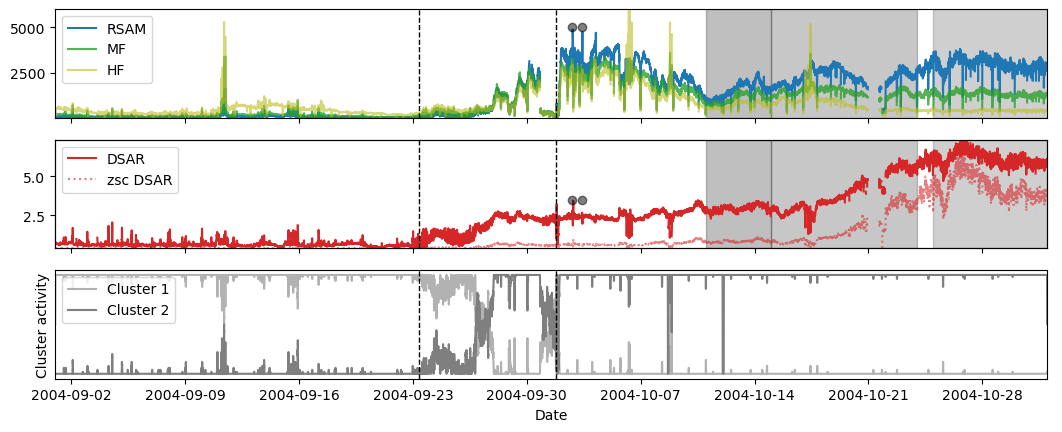

In [62]:
# crate figure --------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(6.4*2, 4.8))

# start plototting seismic data ---------------------------------------------------------------------------------------------------------
ax1.plot(df['rsam'], label='RSAM', alpha=1)
ax1.plot(df['mf'], label='MF', alpha=0.8, color='C2')
ax1.plot(df['hf'], label='HF', alpha=0.6, color='C8')
ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

ax2.plot(df['dsar'], label='DSAR', alpha=1, color='C3')
ax2.plot(np.nan, label='zsc DSAR', linestyle=':', alpha=0.6, color='C3')
ax2.set_ylim(df['dsar'].min(),df['dsar'].max())

ax22 = ax2.twinx()
ax22.plot(df['zsc2_dsar'],linestyle=':', alpha=0.6, color='C3')
ax22.set_ylim(df['zsc2_dsar'].min(),df['zsc2_dsar'].max())
ax22.yaxis.set_major_locator(ticker.NullLocator())

ax3.plot(times, detection_rate_1, label='Cluster 1', alpha=0.6, color="C7")
ax3.plot(times, detection_rate_2, label='Cluster 2', color="C7")
ax3.yaxis.set_major_locator(ticker.NullLocator())

ax1.axvline(datetime.datetime(2004,9,23,9), color='black', linewidth=1, linestyle='--')
ax2.axvline(datetime.datetime(2004,9,23,9), color='black', linewidth=1, linestyle='--')
ax3.axvline(datetime.datetime(2004,9,23,9), color='black', linewidth=1, linestyle='--')

ax1.axvline(datetime.datetime(2004,10,1,19), color='black', linewidth=1, linestyle='--')
ax2.axvline(datetime.datetime(2004,10,1,19), color='black', linewidth=1, linestyle='--')
ax3.axvline(datetime.datetime(2004,10,1,19), color='black', linewidth=1, linestyle='--')

# plot explosions and/or tremor
ax1.plot(df_expl_tremor.index.to_pydatetime(),5000*np.ones(len(df_expl_tremor.index)), linestyle='', marker='o', color='k', alpha=0.5)
ax2.plot(df_expl_tremor.index.to_pydatetime(),3.5*np.ones(len(df_expl_tremor.index)), linestyle='', marker='o', color='k', alpha=0.5)


# plot dome periodes
color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

for i in range(len(activity_dome_start)):
    sdate = activity_dome_start.index[i].to_pydatetime() # start date
    edate = activity_dome_end.index[i].to_pydatetime() # end date
#     plt.axvline(sdate, color='k',linestyle=':')
    ax1.axvspan(sdate, edate, alpha=0.25, color=color[i])
    ax2.axvspan(sdate, edate, alpha=0.25, color=color[i])

# X-Label
ax3.set_xlim(df.index[0],df.index[-1])
ax3.set_xlabel("Date")
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))# %H:%M:%S
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=7))

# Y-Label

# ax3.set_yticks([])
ax3.set_ylabel("Cluster activity")


ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')

# plt.savefig('scatseisnet_RSAM_DSAR_activity.png', dpi=300, bbox_inches='tight')
plt.show()